# 본 파일은 Federated Learning을 활용하여 Image Classification 성능을 향상시키는 과정을 직접 코드로 구현하여 공부하기 위한 파일임

### dataset : MNIST
### Model : MobileNetV2
### Number of Clients : 3 
### FL aggregation Algorithms : FedAvg / FedProx 

# 1. 라이브러리 및 훈련 Parameter setup 

## 1.1 Library import

In [18]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset # 데이터셋 관리 라이브러리, Subset은 기존 데이터셋의 부분집합 생성을 도움. 
from torchvision import datasets, transforms, models #Pytorch의 이미지 데이터 관리. transforms는 이미지를 manipulate하는데 쓰임. 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import copy # 객체를 복사하는데 쓰임, DL에서는 모델의 가중치를 복사하는데 쓰임. 
import sys
from tqdm import tqdm 

## 1.2 Parameter setting

In [19]:
num_clients = 3
global_epochs =15
local_epochs = 7
batch_size = 32
learning_rate = 0.001
aggregation_method = "FedProx" #option : "FedAvg" , "FedProx"
mu = 0.1 #Proximal term for FedProx 

# 2. MNIST 데이터 셋 준비와 Non-IID 분배

## 2.1 MNIST 데이터셋 다운로드

In [20]:
# 데이터셋 로드 및 전처리 (MNIST)
transform = transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])
mnist_data= datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

## 2.2 Non-IID 데이터 분배

In [21]:
# non-iid (비독립 동일 분포) data 분배 
def distribution_data_non_iid(data,num_clients):
    client_data = [] # 데이터의 부분집합을 담을 list 생성 
    class_ranges = [(0,3), (4,6), (7,9)] #각 클라이언트 별로 class 범위를 할당 
    for i in range(num_clients):
        # 할당된 클래스의 범위에 따른 샘플들의 index를 가져옴. 
        indicies = [idx for idx, (img, label) in enumerate(data) if class_ranges[i][0] <= label <= class_ranges[i][1]]
        client_subset = Subset(data,indicies) # 변수에 해당 범위의 data subset을 할당. 
        client_data.append(client_subset) # list 에 append함. 
    return client_data

client_data = distribution_data_non_iid(mnist_data, num_clients)


### non-iid data 분배 결과 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

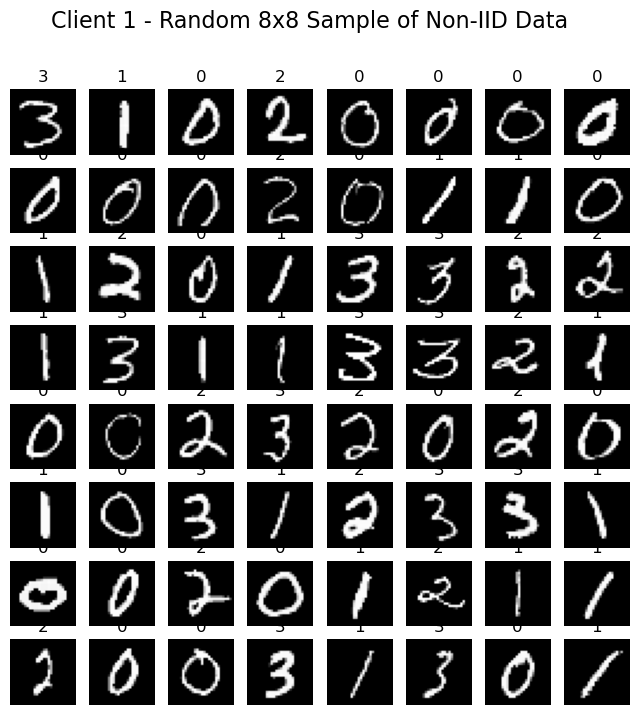

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB dat

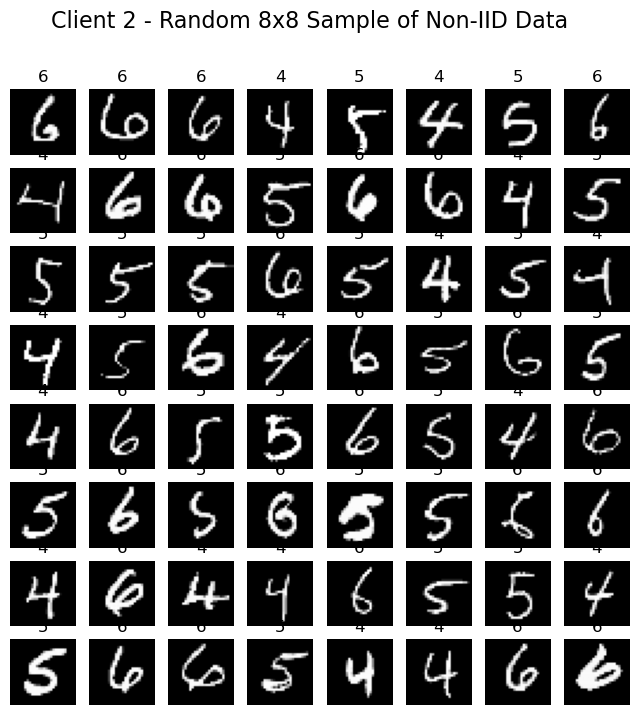

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB dat

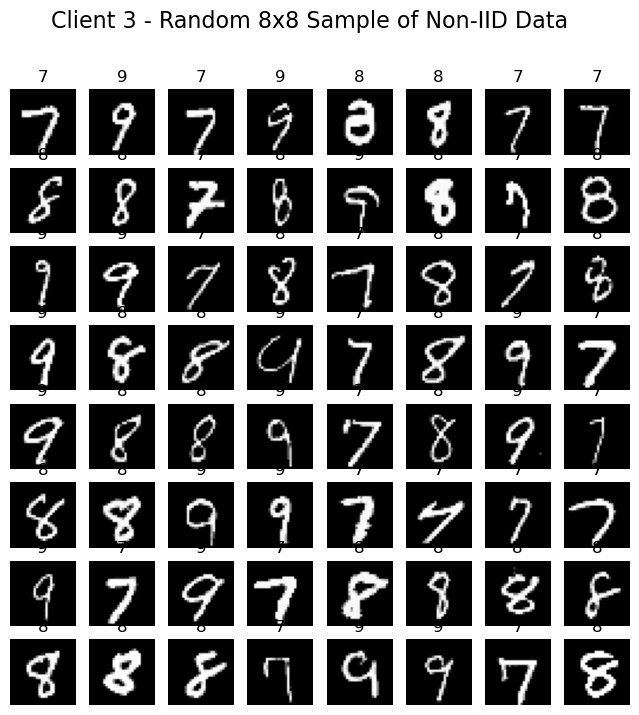

In [5]:
import matplotlib.pyplot as plt 

# Function to visualize 8x8 random samples from each client's dataset
def visualize_client_data(client_data):
    for i, client_subset in enumerate(client_data):
        # Sample 64 random images from each client's dataset
        indices = np.random.choice(len(client_subset), 64, replace=False)
        sample_loader = DataLoader(Subset(client_subset, indices), batch_size=64, shuffle=False)
        
        # Retrieve one batch of images and labels
        images, labels = next(iter(sample_loader))
        
        # Plot the images in an 8x8 grid
        fig, axes = plt.subplots(8, 8, figsize=(8, 8))
        fig.suptitle(f"Client {i+1} - Random 8x8 Sample of Non-IID Data", fontsize=16)
        for j, (img, label) in enumerate(zip(images, labels)):
            row, col = divmod(j, 8)
            axes[row, col].imshow(img.permute(1, 2, 0).squeeze(), cmap='gray')
            axes[row, col].set_title(f"{label.item()}")
            axes[row, col].axis('off')
        plt.show()

# Visualize non-iid distribution for each client
visualize_client_data(client_data)

## 2.3 CUDA 사용

In [22]:
# 훈련 Device 를 GPU로 변경
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 3. 모델 아키텍쳐 정의 (MobileNetv2)

In [23]:
# MobileNetv2 모델 정의 
def create_mobilenet_model():
    model = models.mobilenet_v2(pretrained = True)
    model.classifier[1] = nn.Linear(model.last_channel, 10) #MNIST는 10개의 클래스가 있음. 
    model=  model.to(device)
    return model 

# 4. 클라이언트와 글로벌 모델 훈련 함수

## 4.1. 클라이언트 훈련

In [28]:
""" FedAvg, FedProx 선택. Default로 FedAvg """
#FedAVg : Local training의 standard
def train_client_model_fedavg(model, data, epochs):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) 
    loader = DataLoader(data, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        for images, labels in tqdm(loader, desc = f"Local Epoch {epoch+1}/{epochs}", leave=False) : 
            images, labels = images.to(device), labels.to(device) # Data를 GPU로 옮김
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
    return model.state_dict() # 모델의 현재 파라미터를 retrieves 

#FedProx : proximal term으로 로컬 훈련
def train_client_model_fedprox(model, global_weights, data, epochs, mu):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loader = DataLoader(data, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        for images, labels in tqdm(loader, desc = f"Local Epoch {epoch+1}/{epochs}", leave=False) : 
            images, labels = images.to(device), labels.to(device)  # Move data to GPU if available
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)

            #proximal term 추가
            prox_term = 0.0
            for name, param in model.named_parameters():
                if name in global_weights:
                    global_param = global_weights[name].to(device)  # Move global parameter to device
                    prox_term += torch.sum((param - global_param) ** 2)
            loss += (mu / 2) * prox_term
            
            loss.backward()
            optimizer.step()
    

    return model.state_dict() # 모델의 현재 파라미터를 retrieves 


## 4.2. 글로벌 모델 훈련

# 5. 평가 (클라이언트 모델의 성능 향상 결과 확인)

In [25]:
def evaluate_model(model, test_data):
    model.eval()
    loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU if available
            output = model(images)
            _, preds = torch.max(output, 1)
            all_preds.extend(preds.cpu().numpy())  # Move to CPU for metric calculation
            all_labels.extend(labels.cpu().numpy())
    
    # Compute evaluation metrics with zero_division=1 to suppress warnings
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)
    cm = confusion_matrix(all_labels, all_preds)

    # Return metrics as dictionary
    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
    }
    return metrics




## 5.1 communication cost 계산

In [26]:
def calculate_communication_cost(state_dicts):
    total_cost = 0
    for state_dict in state_dicts:
        for param in state_dict.values():
            total_cost += param.numel() * param.element_size()
    return total_cost / (1024 ** 2)  # Convert bytes to megabytes (MB)


# 6. FL 실행

## 6.1. FedAvg 

In [11]:
def federated_learning(global_epochs, client_data, aggregation_method, mu=0.1):
    global_model = create_mobilenet_model()
    total_communication_cost = 0.0

    for global_epoch in range(global_epochs):
        print(f"\nGlobal Epoch {global_epoch+1}/{global_epochs}")
        client_weights = []
        round_comm_cost = 0
        
        # Distribute the global model to clients and train
        for i in range(num_clients):
            local_model = create_mobilenet_model()
            local_model.load_state_dict(global_model.state_dict())  # Initialize with global weights
            
            # Calculate the communication cost for sending the model to each client
            round_comm_cost += calculate_communication_cost([global_model.state_dict()])
            
            # Train using FedAvg or FedProx based on chosen method
            if aggregation_method == "FedAvg":
                client_weight = train_client_model_fedavg(local_model, client_data[i], local_epochs)
            elif aggregation_method == "FedProx":
                client_weight = train_client_model_fedprox(local_model, global_model.state_dict(), client_data[i], local_epochs, mu)
            
            client_weights.append(client_weight)
            
            # Calculate the communication cost for sending the model back to the server
            round_comm_cost += calculate_communication_cost([client_weight])
            
            # Evaluate each client's model
            client_metrics = evaluate_model(local_model, mnist_test)
            print(f"Client {i+1} Evaluation Metrics: {client_metrics}")

        # Aggregate client weights (FedAvg-style aggregation) with type casting to float
        new_state_dict = global_model.state_dict()
        for key in new_state_dict.keys():
            new_state_dict[key] = torch.stack([client_weights[i][key].float() for i in range(num_clients)], dim=0).mean(dim=0)
        global_model.load_state_dict(new_state_dict)
        
        # Evaluate global model after aggregation
        global_metrics = evaluate_model(global_model, mnist_test)
        print(f"Global Model Evaluation Metrics after Round {global_epoch+1}: {global_metrics}")
        
        # Add this round's communication cost to the total
        total_communication_cost += round_comm_cost
        print(f"Communication Cost for Round {global_epoch+1}: {round_comm_cost:.2f} MB")

    return global_model, total_communication_cost

# Summarize final results
def summarize_results(global_model, test_data, total_communication_cost):
    print("\nFinal Evaluation of Global Model on Test Data:")
    final_metrics = evaluate_model(global_model, test_data)
    print("Accuracy:", final_metrics['accuracy'])
    print("Precision:", final_metrics['precision'])
    print("Recall:", final_metrics['recall'])
    print("F1 Score:", final_metrics['f1_score'])
    print("\nTotal Communication Cost for All Rounds: {:.2f} MB".format(total_communication_cost))

# Run federated learning
global_model, total_communication_cost = federated_learning(global_epochs, client_data, aggregation_method, mu)
summarize_results(global_model, mnist_test, total_communication_cost)

/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Global Epoch 1/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.4135, 'precision': 0.7771947448523213, 'recall': 0.4135, 'f1_score': 0.25621652758628805}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2826, 'precision': 0.8140992343755233, 'recall': 0.2826, 'f1_score': 0.1403528574273311}


Client 3 Evaluation Metrics: {'accuracy': 0.2999, 'precision': 0.7963596635257016, 'recall': 0.2999, 'f1_score': 0.14482262737561738}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 1: {'accuracy': 0.1032, 'precision': 0.9074502400000001, 'recall': 0.1032, 'f1_score': 0.019307904278462656}
Communication Cost for Round 1: 51.98 MB

Global Epoch 2/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.4141, 'precision': 0.7814217086493754, 'recall': 0.4141, 'f1_score': 0.25844326819732866}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2825, 'precision': 0.8039582473333301, 'recall': 0.2825, 'f1_score': 0.13136223038667524}


Client 3 Evaluation Metrics: {'accuracy': 0.3001, 'precision': 0.8139793554825963, 'recall': 0.3001, 'f1_score': 0.1604747737073777}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 2: {'accuracy': 0.1032, 'precision': 0.9074502400000001, 'recall': 0.1032, 'f1_score': 0.019307904278462656}
Communication Cost for Round 2: 51.98 MB

Global Epoch 3/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.4139, 'precision': 0.7647632015591113, 'recall': 0.4139, 'f1_score': 0.24912273026526163}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2819, 'precision': 0.8086964648369386, 'recall': 0.2819, 'f1_score': 0.13505306590238414}


Client 3 Evaluation Metrics: {'accuracy': 0.2994, 'precision': 0.7943691410349151, 'recall': 0.2994, 'f1_score': 0.1433709073941972}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 3: {'accuracy': 0.1679, 'precision': 0.8584206273486107, 'recall': 0.1679, 'f1_score': 0.07853137015167211}
Communication Cost for Round 3: 51.98 MB

Global Epoch 4/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.4138, 'precision': 0.7870292752249362, 'recall': 0.4138, 'f1_score': 0.26196036935121575}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2813, 'precision': 0.813036095148486, 'recall': 0.2813, 'f1_score': 0.13800484288192422}


Client 3 Evaluation Metrics: {'accuracy': 0.2999, 'precision': 0.7944683319536107, 'recall': 0.2999, 'f1_score': 0.1432875728302612}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 4: {'accuracy': 0.2614, 'precision': 0.8376319228820573, 'recall': 0.2614, 'f1_score': 0.14549327861797492}
Communication Cost for Round 4: 51.98 MB

Global Epoch 5/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.415, 'precision': 0.7684719144886208, 'recall': 0.415, 'f1_score': 0.25167803811596096}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2825, 'precision': 0.8096803366436793, 'recall': 0.2825, 'f1_score': 0.136111413945264}


Client 3 Evaluation Metrics: {'accuracy': 0.3002, 'precision': 0.8105586640918363, 'recall': 0.3002, 'f1_score': 0.15559294167535576}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 5: {'accuracy': 0.4142, 'precision': 0.7683338702947862, 'recall': 0.4142, 'f1_score': 0.25122189401056166}
Communication Cost for Round 5: 51.98 MB

Global Epoch 6/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.4151, 'precision': 0.759853006179859, 'recall': 0.4151, 'f1_score': 0.245881255006956}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2828, 'precision': 0.8081007899921042, 'recall': 0.2828, 'f1_score': 0.13498044036124351}


Client 3 Evaluation Metrics: {'accuracy': 0.2997, 'precision': 0.8013648032414968, 'recall': 0.2997, 'f1_score': 0.14920722145834775}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 6: {'accuracy': 0.4144, 'precision': 0.7645976528667624, 'recall': 0.4144, 'f1_score': 0.24889703322527085}
Communication Cost for Round 6: 51.98 MB

Global Epoch 7/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.415, 'precision': 0.7718109029619445, 'recall': 0.415, 'f1_score': 0.25419508191752527}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2829, 'precision': 0.8086560781363065, 'recall': 0.2829, 'f1_score': 0.13552217668397856}


Client 3 Evaluation Metrics: {'accuracy': 0.2985, 'precision': 0.8193968098646294, 'recall': 0.2985, 'f1_score': 0.16302405515772722}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 7: {'accuracy': 0.4143, 'precision': 0.7707755430988488, 'recall': 0.4143, 'f1_score': 0.25302002770859794}
Communication Cost for Round 7: 51.98 MB

Global Epoch 8/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.4146, 'precision': 0.7681858229447793, 'recall': 0.4146, 'f1_score': 0.2511551676023162}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2823, 'precision': 0.8078373578772373, 'recall': 0.2823, 'f1_score': 0.13461308785402107}


Client 3 Evaluation Metrics: {'accuracy': 0.3001, 'precision': 0.7938760556599562, 'recall': 0.3001, 'f1_score': 0.14287867564805964}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 8: {'accuracy': 0.3998, 'precision': 0.8014546482005093, 'recall': 0.3998, 'f1_score': 0.26623225214931107}
Communication Cost for Round 8: 51.98 MB

Global Epoch 9/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.4148, 'precision': 0.7618947030920317, 'recall': 0.4148, 'f1_score': 0.24722266465416118}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2829, 'precision': 0.8067370939775492, 'recall': 0.2829, 'f1_score': 0.13461583134851593}


Client 3 Evaluation Metrics: {'accuracy': 0.2999, 'precision': 0.7905695774487297, 'recall': 0.2999, 'f1_score': 0.1400491989281142}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 9: {'accuracy': 0.4128, 'precision': 0.777228617396884, 'recall': 0.4128, 'f1_score': 0.2564939721214756}
Communication Cost for Round 9: 51.98 MB

Global Epoch 10/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.415, 'precision': 0.7587530418734646, 'recall': 0.415, 'f1_score': 0.2451102814584512}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2824, 'precision': 0.8049611622708273, 'recall': 0.2824, 'f1_score': 0.13219014277413121}


Client 3 Evaluation Metrics: {'accuracy': 0.2988, 'precision': 0.7888684303991887, 'recall': 0.2988, 'f1_score': 0.13920243866625073}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 10: {'accuracy': 0.4136, 'precision': 0.7872638732630568, 'recall': 0.4136, 'f1_score': 0.2617478031422931}
Communication Cost for Round 10: 51.98 MB

Global Epoch 11/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.4153, 'precision': 0.7678797989029817, 'recall': 0.4153, 'f1_score': 0.25133055634677265}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2823, 'precision': 0.8075281798279894, 'recall': 0.2823, 'f1_score': 0.13451749219520492}


Client 3 Evaluation Metrics: {'accuracy': 0.2995, 'precision': 0.6883008093280645, 'recall': 0.2995, 'f1_score': 0.14078534403144707}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 11: {'accuracy': 0.4105, 'precision': 0.7801072502667732, 'recall': 0.4105, 'f1_score': 0.2574777828813907}
Communication Cost for Round 11: 51.98 MB

Global Epoch 12/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.4148, 'precision': 0.7611395728102595, 'recall': 0.4148, 'f1_score': 0.24667267476864854}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2833, 'precision': 0.7898659093943781, 'recall': 0.2833, 'f1_score': 0.1354084689201172}


Client 3 Evaluation Metrics: {'accuracy': 0.2992, 'precision': 0.7895732160715949, 'recall': 0.2992, 'f1_score': 0.13900277328921243}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 12: {'accuracy': 0.4126, 'precision': 0.7779714121693329, 'recall': 0.4126, 'f1_score': 0.25648454512498203}
Communication Cost for Round 12: 51.98 MB

Global Epoch 13/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.4148, 'precision': 0.7720951102129309, 'recall': 0.4148, 'f1_score': 0.2537179168892263}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2826, 'precision': 0.8081289064744915, 'recall': 0.2826, 'f1_score': 0.13520341130052965}


Client 3 Evaluation Metrics: {'accuracy': 0.2999, 'precision': 0.7923847826247242, 'recall': 0.2999, 'f1_score': 0.14173006109783254}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 13: {'accuracy': 0.4147, 'precision': 0.7617145075968927, 'recall': 0.4147, 'f1_score': 0.24701894068651892}
Communication Cost for Round 13: 51.98 MB

Global Epoch 14/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.4115, 'precision': 0.7642854418641191, 'recall': 0.4115, 'f1_score': 0.24764328771704286}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2825, 'precision': 0.8091558345503499, 'recall': 0.2825, 'f1_score': 0.13561529195737954}


Client 3 Evaluation Metrics: {'accuracy': 0.2996, 'precision': 0.7919686696203044, 'recall': 0.2996, 'f1_score': 0.14124991767380252}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 14: {'accuracy': 0.4128, 'precision': 0.7666513364225019, 'recall': 0.4128, 'f1_score': 0.24951889657656628}
Communication Cost for Round 14: 51.98 MB

Global Epoch 15/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.415, 'precision': 0.7627754369872513, 'recall': 0.415, 'f1_score': 0.2478559171107159}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2822, 'precision': 0.8076105072179457, 'recall': 0.2822, 'f1_score': 0.13434244685388647}


Client 3 Evaluation Metrics: {'accuracy': 0.2997, 'precision': 0.7899243010823991, 'recall': 0.2997, 'f1_score': 0.13943447148160176}
Global Model Evaluation Metrics after Round 15: {'accuracy': 0.4476, 'precision': 0.7281194292627416, 'recall': 0.4476, 'f1_score': 0.32507484529778696}
Communication Cost for Round 15: 51.98 MB

Final Evaluation of Global Model on Test Data:
Accuracy: 0.4476
Precision: 0.7281194292627416
Recall: 0.4476
F1 Score: 0.32507484529778696

Total Communication Cost for All Rounds: 779.65 MB


# 6.2 FedProx 로 실행

In [29]:
def federated_learning(global_epochs, client_data, aggregation_method, mu=0.1):
    global_model = create_mobilenet_model()
    total_communication_cost = 0.0

    for global_epoch in range(global_epochs):
        print(f"\nGlobal Epoch {global_epoch+1}/{global_epochs}")
        client_weights = []
        round_comm_cost = 0
        
        # Distribute the global model to clients and train
        for i in range(num_clients):
            local_model = create_mobilenet_model()
            local_model.load_state_dict(global_model.state_dict())  # Initialize with global weights
            
            # Calculate the communication cost for sending the model to each client
            round_comm_cost += calculate_communication_cost([global_model.state_dict()])
            
            # Train using FedAvg or FedProx based on chosen method
            if aggregation_method == "FedAvg":
                client_weight = train_client_model_fedavg(local_model, client_data[i], local_epochs)
            elif aggregation_method == "FedProx":
                client_weight = train_client_model_fedprox(local_model, global_model.state_dict(), client_data[i], local_epochs, mu)
            
            client_weights.append(client_weight)
            
            # Calculate the communication cost for sending the model back to the server
            round_comm_cost += calculate_communication_cost([client_weight])
            
            # Evaluate each client's model
            client_metrics = evaluate_model(local_model, mnist_test)
            print(f"Client {i+1} Evaluation Metrics: {client_metrics}")

        # Aggregate client weights (FedAvg-style aggregation) with type casting to float
        new_state_dict = global_model.state_dict()
        for key in new_state_dict.keys():
            new_state_dict[key] = torch.stack([client_weights[i][key].float() for i in range(num_clients)], dim=0).mean(dim=0)
        global_model.load_state_dict(new_state_dict)
        
        # Evaluate global model after aggregation
        global_metrics = evaluate_model(global_model, mnist_test)
        print(f"Global Model Evaluation Metrics after Round {global_epoch+1}: {global_metrics}")
        
        # Add this round's communication cost to the total
        total_communication_cost += round_comm_cost
        print(f"Communication Cost for Round {global_epoch+1}: {round_comm_cost:.2f} MB")

    return global_model, total_communication_cost

# Summarize final results
def summarize_results(global_model, test_data, total_communication_cost):
    print("\nFinal Evaluation of Global Model on Test Data:")
    final_metrics = evaluate_model(global_model, test_data)
    print("Accuracy:", final_metrics['accuracy'])
    print("Precision:", final_metrics['precision'])
    print("Recall:", final_metrics['recall'])
    print("F1 Score:", final_metrics['f1_score'])
    print("\nTotal Communication Cost for All Rounds: {:.2f} MB".format(total_communication_cost))

# Run federated learning
global_model, total_communication_cost = federated_learning(global_epochs, client_data, aggregation_method, mu)
summarize_results(global_model, mnist_test, total_communication_cost)


Global Epoch 1/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.3981, 'precision': 0.7694218619914942, 'recall': 0.3981, 'f1_score': 0.24762028240611725}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2815, 'precision': 0.803723624438883, 'recall': 0.2815, 'f1_score': 0.13099365547751704}


Client 3 Evaluation Metrics: {'accuracy': 0.2929, 'precision': 0.827484178572298, 'recall': 0.2929, 'f1_score': 0.16793554436921904}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 1: {'accuracy': 0.2341, 'precision': 0.5482585370826841, 'recall': 0.2341, 'f1_score': 0.1386359615283107}
Communication Cost for Round 1: 51.98 MB

Global Epoch 2/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.4127, 'precision': 0.7773857691072296, 'recall': 0.4127, 'f1_score': 0.25689902139174564}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2705, 'precision': 0.7993867668085579, 'recall': 0.2705, 'f1_score': 0.12509500483413954}


Client 3 Evaluation Metrics: {'accuracy': 0.2958, 'precision': 0.8117233115898653, 'recall': 0.2958, 'f1_score': 0.15576333842686468}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 2: {'accuracy': 0.5127, 'precision': 0.5414600260888239, 'recall': 0.5127, 'f1_score': 0.4458830100532669}
Communication Cost for Round 2: 51.98 MB

Global Epoch 3/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.4131, 'precision': 0.7651106619633028, 'recall': 0.4131, 'f1_score': 0.24824477670382752}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.282, 'precision': 0.8070110944143689, 'recall': 0.282, 'f1_score': 0.13322281752540596}


Client 3 Evaluation Metrics: {'accuracy': 0.2785, 'precision': 0.7953016945876439, 'recall': 0.2785, 'f1_score': 0.13922904142093795}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 3: {'accuracy': 0.4679, 'precision': 0.5895050426399981, 'recall': 0.4679, 'f1_score': 0.33732399517632466}
Communication Cost for Round 3: 51.98 MB

Global Epoch 4/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.4096, 'precision': 0.7622080191830002, 'recall': 0.4096, 'f1_score': 0.24590731907815852}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2821, 'precision': 0.8018655423944964, 'recall': 0.2821, 'f1_score': 0.12912496178634278}


Client 3 Evaluation Metrics: {'accuracy': 0.2982, 'precision': 0.8008268749814609, 'recall': 0.2982, 'f1_score': 0.14811988078893443}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 4: {'accuracy': 0.61, 'precision': 0.6100796119467184, 'recall': 0.61, 'f1_score': 0.5692181528410372}
Communication Cost for Round 4: 51.98 MB

Global Epoch 5/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.4141, 'precision': 0.7728193082363618, 'recall': 0.4141, 'f1_score': 0.2538486296710974}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2821, 'precision': 0.805344048046913, 'recall': 0.2821, 'f1_score': 0.13221133393753215}


Client 3 Evaluation Metrics: {'accuracy': 0.2988, 'precision': 0.7999669221826219, 'recall': 0.2988, 'f1_score': 0.14771931957546225}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 5: {'accuracy': 0.6297, 'precision': 0.672180015199851, 'recall': 0.6297, 'f1_score': 0.5471553684534102}
Communication Cost for Round 5: 51.98 MB

Global Epoch 6/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.4121, 'precision': 0.7841184908448937, 'recall': 0.4121, 'f1_score': 0.26009868575979866}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2673, 'precision': 0.8058981805992536, 'recall': 0.2673, 'f1_score': 0.12793604461159988}


Client 3 Evaluation Metrics: {'accuracy': 0.2973, 'precision': 0.7993645518242095, 'recall': 0.2973, 'f1_score': 0.1469641790225438}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 6: {'accuracy': 0.4986, 'precision': 0.7776463031778954, 'recall': 0.4986, 'f1_score': 0.40363013978008977}
Communication Cost for Round 6: 51.98 MB

Global Epoch 7/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.4145, 'precision': 0.7666727172756898, 'recall': 0.4145, 'f1_score': 0.25004701253130424}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.281, 'precision': 0.8084988839295248, 'recall': 0.281, 'f1_score': 0.13450960447830065}


Client 3 Evaluation Metrics: {'accuracy': 0.2983, 'precision': 0.7902163411549343, 'recall': 0.2983, 'f1_score': 0.1394326006434795}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 7: {'accuracy': 0.6507, 'precision': 0.7046119041339248, 'recall': 0.6507, 'f1_score': 0.6002484050313547}
Communication Cost for Round 7: 51.98 MB

Global Epoch 8/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.414, 'precision': 0.767012544585793, 'recall': 0.414, 'f1_score': 0.250966723108003}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2825, 'precision': 0.8132131050563896, 'recall': 0.2825, 'f1_score': 0.13946837793684064}


Client 3 Evaluation Metrics: {'accuracy': 0.2957, 'precision': 0.7919134229990897, 'recall': 0.2957, 'f1_score': 0.1401624340853891}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 8: {'accuracy': 0.6883, 'precision': 0.68054776617716, 'recall': 0.6883, 'f1_score': 0.6298385111593214}
Communication Cost for Round 8: 51.98 MB

Global Epoch 9/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.4138, 'precision': 0.7633400268306626, 'recall': 0.4138, 'f1_score': 0.24787656339561864}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2792, 'precision': 0.8123080695331361, 'recall': 0.2792, 'f1_score': 0.13663529671897198}


Client 3 Evaluation Metrics: {'accuracy': 0.2861, 'precision': 0.7911413551719356, 'recall': 0.2861, 'f1_score': 0.1377684252516385}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 9: {'accuracy': 0.6436, 'precision': 0.7657249777422492, 'recall': 0.6436, 'f1_score': 0.5977140792749824}
Communication Cost for Round 9: 51.98 MB

Global Epoch 10/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.4141, 'precision': 0.7769271461989001, 'recall': 0.4141, 'f1_score': 0.2570508817775363}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2823, 'precision': 0.8088380370145521, 'recall': 0.2823, 'f1_score': 0.1358948747652522}


Client 3 Evaluation Metrics: {'accuracy': 0.2991, 'precision': 0.8027679920312566, 'recall': 0.2991, 'f1_score': 0.14936364726320497}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 10: {'accuracy': 0.6433, 'precision': 0.7718231002878623, 'recall': 0.6433, 'f1_score': 0.5999961381897939}
Communication Cost for Round 10: 51.98 MB

Global Epoch 11/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.4136, 'precision': 0.7596658494652738, 'recall': 0.4136, 'f1_score': 0.24519636395449365}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2816, 'precision': 0.8068165030040294, 'recall': 0.2816, 'f1_score': 0.13340378784860155}


Client 3 Evaluation Metrics: {'accuracy': 0.2975, 'precision': 0.8183766846570568, 'recall': 0.2975, 'f1_score': 0.1594825447796353}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 11: {'accuracy': 0.718, 'precision': 0.7310177738326935, 'recall': 0.718, 'f1_score': 0.6860675264369401}
Communication Cost for Round 11: 51.98 MB

Global Epoch 12/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.4137, 'precision': 0.7624697507317691, 'recall': 0.4137, 'f1_score': 0.24725448576231687}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2814, 'precision': 0.8073746504894986, 'recall': 0.2814, 'f1_score': 0.13336189922110103}


Client 3 Evaluation Metrics: {'accuracy': 0.2962, 'precision': 0.8193914541973825, 'recall': 0.2962, 'f1_score': 0.16015417440836363}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 12: {'accuracy': 0.5005, 'precision': 0.5649562635394814, 'recall': 0.5005, 'f1_score': 0.4473939800428465}
Communication Cost for Round 12: 51.98 MB

Global Epoch 13/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.4143, 'precision': 0.7597137463295408, 'recall': 0.4143, 'f1_score': 0.24549380752895564}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2821, 'precision': 0.8016912968312466, 'recall': 0.2821, 'f1_score': 0.12924036928300042}


Client 3 Evaluation Metrics: {'accuracy': 0.2989, 'precision': 0.8099210240820789, 'recall': 0.2989, 'f1_score': 0.15458749815583284}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 13: {'accuracy': 0.6378, 'precision': 0.6266733201803084, 'recall': 0.6378, 'f1_score': 0.580257083768457}
Communication Cost for Round 13: 51.98 MB

Global Epoch 14/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.4138, 'precision': 0.7669872866978521, 'recall': 0.4138, 'f1_score': 0.2502741921643578}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2813, 'precision': 0.8093591305445635, 'recall': 0.2813, 'f1_score': 0.13542798277836415}


Client 3 Evaluation Metrics: {'accuracy': 0.2986, 'precision': 0.7991675636437687, 'recall': 0.2986, 'f1_score': 0.146745742279919}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model Evaluation Metrics after Round 14: {'accuracy': 0.6359, 'precision': 0.7610099794135671, 'recall': 0.6359, 'f1_score': 0.5492445902971665}
Communication Cost for Round 14: 51.98 MB

Global Epoch 15/15


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 1 Evaluation Metrics: {'accuracy': 0.4148, 'precision': 0.7643709857617298, 'recall': 0.4148, 'f1_score': 0.24885633072607316}


/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/park/anaconda3/envs/NLtrans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Client 2 Evaluation Metrics: {'accuracy': 0.2828, 'precision': 0.8079544572606714, 'recall': 0.2828, 'f1_score': 0.13457337883899081}


Client 3 Evaluation Metrics: {'accuracy': 0.2992, 'precision': 0.8124953819761684, 'recall': 0.2992, 'f1_score': 0.1571867690293419}
Global Model Evaluation Metrics after Round 15: {'accuracy': 0.6588, 'precision': 0.7010578507087357, 'recall': 0.6588, 'f1_score': 0.6059940173512085}
Communication Cost for Round 15: 51.98 MB

Final Evaluation of Global Model on Test Data:
Accuracy: 0.6588
Precision: 0.7010578507087357
Recall: 0.6588
F1 Score: 0.6059940173512085

Total Communication Cost for All Rounds: 779.65 MB
